This is a statistical fishing expedition. We have a large data set of glycoside hydrolase sequences that have been expressed in _E. coli_ and experimentally characterized from the paper. I am interested in whether we can use this as a benchmark of some kind for our functional comparative modeling protocols. 

We can easily build comparative model all of the sequences with Rosetta and generate some total structure score features, as well as enyzme design features.  

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas 
from sklearn import preprocessing, svm, linear_model, model_selection
import seaborn as sns

In [36]:
df = pandas.read_csv('../data_sets/freezer_annotated.csv', index_col=0)
df['sol_binary'] = df['Sol_exp_(mg/ml)'].map(lambda x: x > 0.135)
print(df.shape)
df.head()

(175, 19)


,Sorting,Organism,PDB,Kindgom,Sol_exp_(mg/ml),Cellobiose_binary(Act),Cellobiose_therm_binary,pH7_40,pH4_40,pH7_60,pH7_80,pH4_80,pH7_80_pre80,pH7_90_pre90,Name,Sequence,organism,uniprot,sol_binary
gene,,,,,,,,,,,,,,,,,,,
SDJGI_31,1,Picrophilus torridus DSM 9790,NaN,Archaea,0.010014,0.0,0.0,0.043767,0.042467,0.042100,0.040767,0.041400,0.04085,0.041333,SDJGI_31,MLPKNFLLGFSLAGFQSEMGISDPDSNSDWWLWVHDPVNIRTGLVS...,Picrophilus torridus,Q6KZ14,False
SDJGI_139,2,Thermoplasma volcanium GSS1,NaN,Archaea,0.399383,1.0,1.0,1.111767,1.494767,1.898033,1.949733,1.498800,2.11665,0.045933,SDJGI_139,MVENNFPEDFKFGWSQSGFQSEMGYDNAMDDKSDWYVWVHDKENIQ...,Thermoplasma volcanium,NaN,True
SDJGI_35,3,Magnaporthe grisea Y34,NaN,Eukaryote,0.012451,0.0,0.0,0.040667,0.040733,0.040500,0.040533,0.042033,0.04080,0.041333,SDJGI_35,MSLPKDFLWGFATASYQIEGAIDKDGRGPSIWDTFTAIPGKVADGS...,Magnaporthe grisea,NaN,False
SDJGI_137,4,Thermococcus kodakarensis KOD1,NaN,Archaea,0.004728,0.0,0.0,0.041167,0.041233,0.040867,0.041000,0.042533,0.04190,0.042100,SDJGI_137,MREFAWGVVQSAFQFEMGDPLRRFIDTRTDWWHWVRDPLNIKNDLV...,Thermococcus kodakarensis,Q5JDV2,False
SDJGI_42,5,Saccharophagus degradans 2-40,NaN,Bacteria,0.281507,1.0,0.0,1.795000,0.701667,1.006167,1.276900,0.511700,0.04050,0.041500,SDJGI_42,MNRLTLPPSSRLRSKEFTFGVATSSYQIEGGIDSRLPCNWDTFCEQ...,Saccharophagus degradans,Q21KX3,True


In [37]:
f = pandas.read_csv('../feature_sets/family__holo.csv', index_col='id')
f.sample(5)

,Unnamed: 0,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,...,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,description
id,,,,,,,,,,,,,,,,,,,,,
SDJGI_59,9,-2754.98,421.04,-75.27,0.0,0.61,0.61,168.0,431.0,230.0,...,443.0,-2.25,4.50,-0.45,0.20,-0.49,0.97,1.0,3.0,input_pose_0010
N6TEA0_DENPD,4,-3293.93,472.27,-81.25,0.0,0.58,0.59,153.0,505.0,257.0,...,502.0,-5.70,1.86,-1.59,2.75,-7.41,0.91,4.0,1.0,input_pose_0005
A0A022S278_ERYGU,8,-3263.79,381.94,-91.62,0.0,0.67,0.67,179.0,512.0,298.0,...,501.0,-6.79,5.50,-1.32,2.27,-9.58,0.98,8.0,2.0,input_pose_0009
F9UUH7_LACPL,3,-3460.45,338.76,-97.85,0.0,0.70,0.69,180.0,486.0,276.0,...,487.0,-3.35,1.92,-0.55,0.10,-2.71,0.87,1.0,2.0,input_pose_0004
Q4A0W8_STAS1,6,-3280.01,420.79,-86.97,0.0,0.67,0.67,147.0,456.0,267.0,...,477.0,-6.60,1.53,-1.58,0.08,-9.20,0.87,6.0,1.0,input_pose_0007


In [38]:
len([n for n in f.index if 'SDJ' in n])

169

In [39]:
j = df.join(f).select_dtypes(['float64']).dropna()
j.shape

(164, 70)

In [40]:
j.head()

,Sol_exp_(mg/ml),Cellobiose_binary(Act),Cellobiose_therm_binary,pH7_40,pH4_40,pH7_60,pH7_80,pH4_80,pH7_80_pre80,pH7_90_pre90,...,SR_4_nlpstat_pm,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
SDJGI_1,0.015022,0.0,0.0,0.039767,0.040133,0.039633,0.040033,0.041233,0.03980,0.040933,...,0.69,495.0,1.55,4.78,0.00,720.42,7.10,0.32,1.0,0.0
SDJGI_10,0.008643,0.0,0.0,0.041333,0.041700,0.040933,0.041000,0.043533,0.04140,0.042100,...,0.59,567.0,-7.03,5.81,-1.24,0.25,-10.07,0.99,7.0,2.0
SDJGI_100,0.000675,0.0,0.0,0.040267,0.040633,0.040067,0.040400,0.041000,0.04045,0.041433,...,0.70,475.0,-3.01,5.73,-0.46,32.41,-2.02,0.95,3.0,2.0
SDJGI_101,0.012157,0.0,0.0,0.041100,0.041333,0.043167,0.040267,0.047300,0.04065,0.041333,...,0.79,451.0,-5.43,4.86,-0.94,0.15,-6.85,1.00,2.0,4.0
SDJGI_103,0.018201,0.0,0.0,0.040700,0.040533,0.040167,0.040467,0.040900,0.04030,0.041067,...,0.78,417.0,-7.77,2.82,-1.49,0.31,-11.54,0.94,4.0,1.0


In [41]:
targets = j.iloc[:, 0:11]
features = j.iloc[:, 11:]

targets.shape, features.shape

((164, 11), (164, 59))

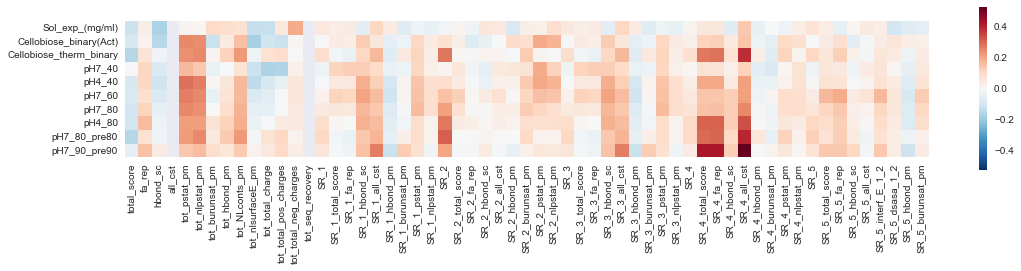

In [42]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(j.corr(method='pearson').iloc[11:, 0:10].T, ax=ax, square=1)

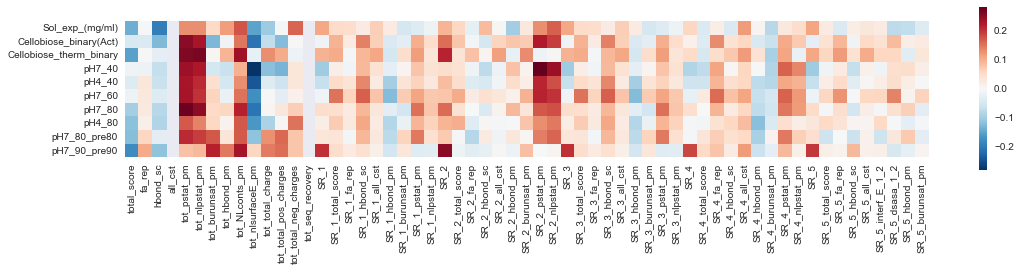

In [43]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(j.corr(method='spearman').iloc[11:, 0:10].T, ax=ax, square=1)

Continuous variables (Pearson and Spearman correlation) 

In [44]:
binary_var = [n for n in targets.columns if 'binary' in n]
binary_var

['Cellobiose_binary(Act)', 'Cellobiose_therm_binary']

In [45]:
clf = svm.SVC(C=1, probability=1, class_weight='balanced', kernel='rbf')
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
clf.fit(X_train, y_train) 
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test) 
fpr, tpr, _ = metrics.roc_curve(y_test, prob[:, 1], pos_label=1) 
auc = metrics.roc_auc_score(y_test, prob[:, 1]) 
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('AUC {0:2.2}'.format(auc))
fig.show()

NameError: name 'metrics' is not defined

(164, 57)


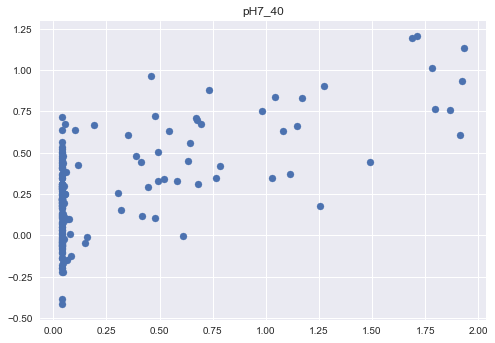

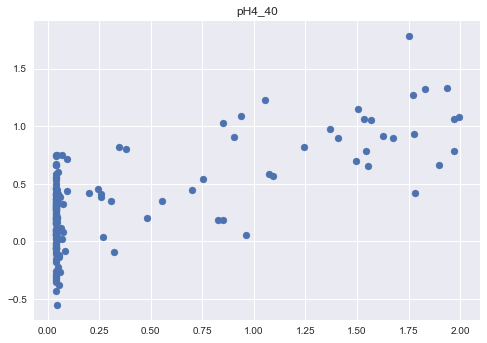

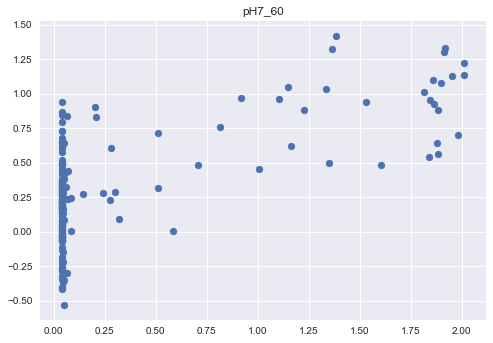

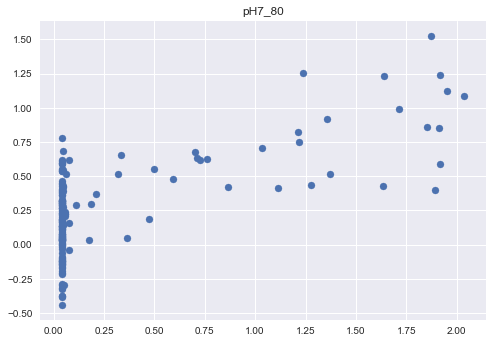

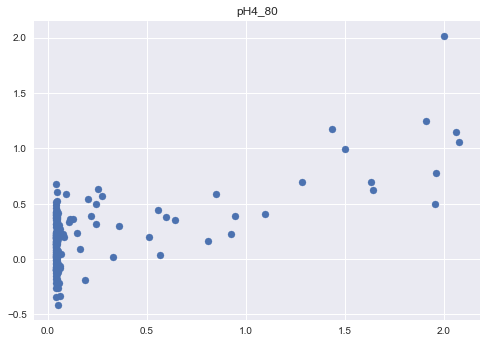

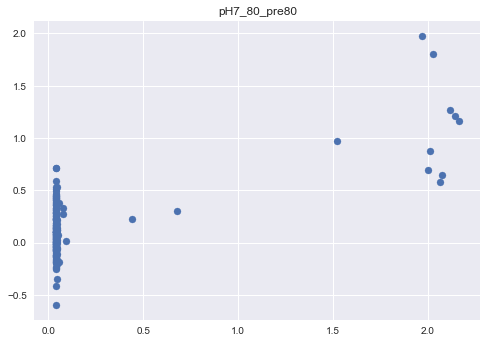

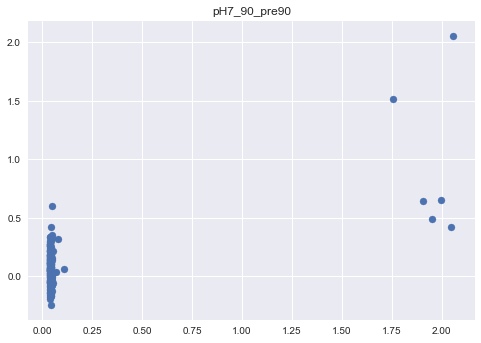

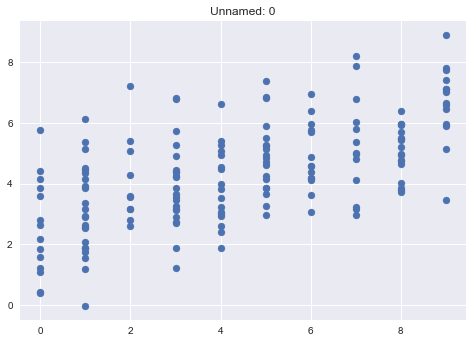

In [11]:
scaler = preprocessing.StandardScaler()
var = feature_selection.VarianceThreshold()
X = scaler.fit_transform(var.fit_transform(features)) 
print(X.shape)
#fig, ax = plt.subplots(ncols=len(targets.columns), figsize=(len(targets.columns)*2, 3))
for n, target in enumerate(targets.columns[3:]):
    y = targets[target] 
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    pred = clf.predict(X) 
    plt.scatter(y, pred) 
    plt.title(target) 
    plt.show()

In [49]:
binary_targets = targets.iloc[:, 1:3]
binary_targets.shape

(164, 2)

In [60]:
# let's just look at the publication data 

df = pandas.read_excel('../data_sets/Heins14.xlsx') 
df.head()

,Expression_binary,NIMS_Max_temp,Cellobiose NIMS_Activity (Binary),pNPG A400 nm *,pNPG_binary,Number,ID (accesion_Species)*,Kingdom,Sequence,Soluble Expression (mg/ml)
0,0,-,0,0.039767,0,1,ABV54716.1_Trifolium-repens,Eukaryota,MHAFKPLPISFDDFSDLNRSCFAPGFVFGTASSAFQYEGAAFEDGK...,0.015022
1,0,-,0,0.040567,0,2,CBD28469.1_Oryza-sativa-Japonica-Group,Eukaryota,MAARRANCALVLVLALALLAARDAGAAAVPKPNWLGGLSRAAFPKR...,0.018310
2,0,-,0,0.040350,0,3,ACZ37931.1_Sphaerobacter-thermophilus-DSM-20745,Bacteria,MADQIHRREFPEGFKWGVATSAYQIEGAWDEDGKGQSIWDTYAHTP...,0.014000
3,1,60,1,1.257367,1,4,ACL74759.1_Clostridium-cellulolyticum-H10,Bacteria,MAFKEGFVWGTATASYQIEGAVNEGGRGESVWDEFCRMKGKIDDDD...,0.418059
4,0,-,0,0.041667,0,5,CAC08178.1_Homo-sapiens,Eukaryota,MAFPAGFGWAAATAAYQVEGGWDADGKGPCVWDTFTHQGGERVFKN...,0.012039


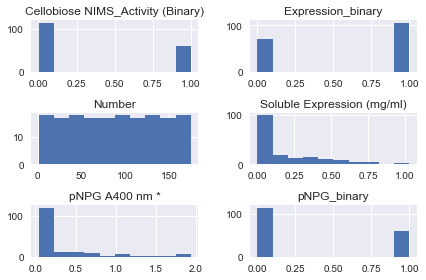

In [66]:
df.hist()
plt.tight_layout()